<a href="https://colab.research.google.com/github/nathantthai/SFL-SDE/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python3
__author__ = "Nathan Thai"
__email__ = "nathantthai@gmail.com"
__phone__ = "832-528-7224"

# Section 1

## What is a Data Lake? Explain its benefits, how it differs from a data warehouse, and how it might benefit a client. 

A data lake is typically a massive collective repository of unstructured and structured data that is stored in its native format. Its main benefit is allowing users to store all kinds of data - from different sources, size, and formats - in a centralized and scalable platform. As a result, data can be extracted, stored, processed, and analyzed in a cost-effective and efficient manner.

A data lake can be scaled to manage, store, and process impressive amount of data, which is making it suitable for enterprises of all sizes. Allowing data to be stored in its native format eliminates the need for costly prior data transformations. The best of all is enabling businesses to conduct insightful and advanced analysis on data from a variety of sources.

In contrary to a data lake, a data warehouse is an orchestrated repository that is used to manage and store structured data from different sources. Data goes through preprocessing to ensure consistency and accuracy prior to being stored in a data warehouse.

Data from a data warehouse is typically used for predetermined queries and reports to support business reporting needs while data from a data lake is more for exploratory analysis and commonly used in data mining and artificial intelligence capacities.

As suggested by the name, a data lake is like a lake comprises many native species, a variety of minerals, and unfiltered water. Whereas a data warehouse is like a pool that should only be composed of clean water and chlorine.

A data lake can offer clients the benefit of a centralized repository for all their data, and that should reduce the cost and time with managing and analysis. 
Since all the data is in one central location, it allows businesses to process a large volume of data in real-time.
Another major benefit is enabling the integration of data from different sources, which support advanced analytics that provide more generalized insights and better decision-making.


## Explain serverless architecture.  What are its pros and cons? 

Serverless architecture is a cloud computing model where developers implement code for functions and applications and the cloud provider manages the infrastructure, servers and scaling of the application. An application in a serverless architecture is typically made up of smaller and independent functions that are only invoked as needed. The functions are coded by developers to be triggered by an user request or/and a scheduled event, and the cloud provider manages the infrastructure and resources needed to execute the function. The benefit of a serverless architecture is providing clear and distinctive responsibilities for both developer and cloud provider, and as a result, they can maximize their potential in fulfilling their duties. For example, developers can solely concentrate on implementing and improving the application for the business needs and not having to worry about managing the infrastructure, and the counterpart will do their job in maintaining servers.

For businesses, the pros of serverless architecture are reduced management overhead and time to market, cost-effective, and scalability. In comparison to traditional server-based architecture, businesses only pay for the resources they use and are not affected by the management overhead cost that takes to maintain the infrastructure and servers. They can scale up their application without the bound of additional management or configuration. Developers can focus on just implementing, testing, and deploying code, and that means reducing the time for the business to bring the product to market.

There are drawbacks of a serverless architecture. Because developers have limited control over the infrastructure, it can be difficult for them to optimize the application’s performance and scalability. By the same token, it is also difficult for the developer to debug issues that involve the conjunction of hardware. Developers have to tailor the application to a vendor’s specific serverless architecture specifications, making it challenging to switch provider.


## Please provide a diagram for an ETL pipeline (e.g., Section 2) using serverless AWS services. Describe each component and its function within the pipeline. 

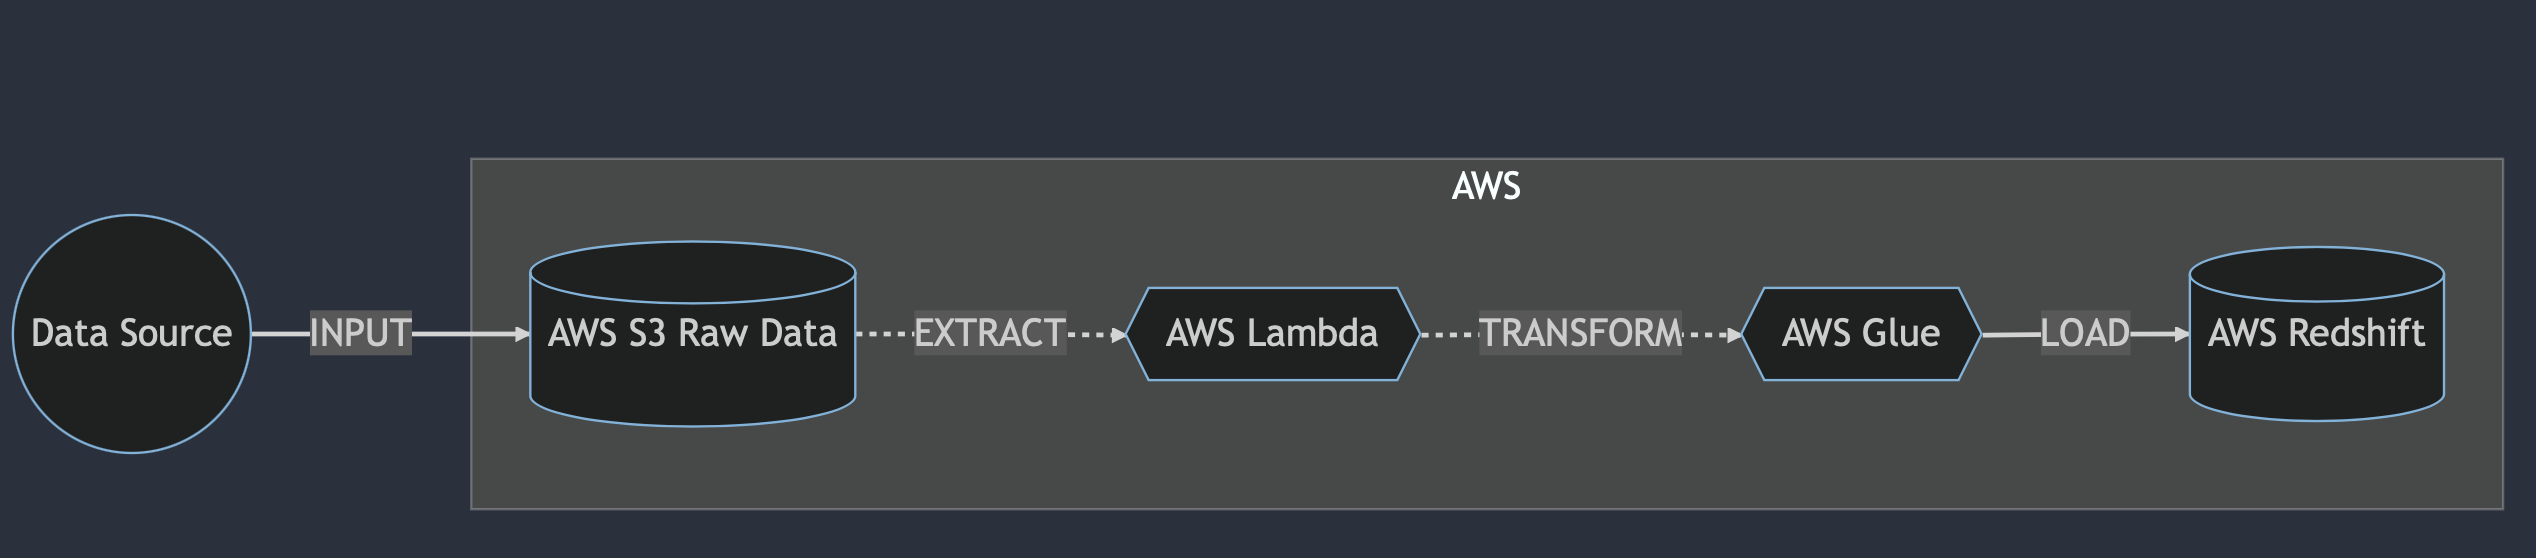

### Data Source
The source of data could be anything from a database to a CSV file, like in Section 2.

### AWS S3
S3 stands for simple storage service and is an object storage service that allows client to store and retrieve data from anywhere on the web. In this pipeline, the AW S3 raw data to store the source data before it is processed.

### AWS Lambda
Lambda is a serverless computing service that is used to perform custom transformations on the data that cannot be performed by Glue. Lambda is also used to trigger jobs based on the events occurring in AWS S3. For instance, when new data is presented to S3, Lambda can be used to trigger AWS Glue job to transform the data.

### AWS Glue
In this pipeline, Glue is used to transform the source data into a predefined format that is suitable for analysis. 

### AWS Redshift
Redshift is a data warehousing service that is used to store and analyze large amounts of structured data. The transformed data from Glue is loaded into Redshift for querying and analysis. 

### Diagram
The above pipeline is a big picture with major components of ETL using serverless architecture from AWS. Amazon also offers other micro ETL services and features that work in conjunction or substitution , and they are not depicted in this pipeline.



## Describe modern MLOps and how organizations should be approaching management from a tool and system perspective. 

Modern MLOps is a way of orchestrating tools and systems that allow data scientist and engineers to quickly and reliably turn machine learning models from development to production. To achieve such remarkable developing cycle at a fast pace, the emphasis must be on automation, reproducibility, scalability, and collaboration. Some of the key tools and systems that organizations should really be considering are version control (eg. git), continuous integration and deployment (CI/CD), containerization (eg. Docker), and monitoring and logging (eg. Prometheus). 

Git is an essential tool to track changes to machine learning models, code, and configuration, and it seamlessly enables engineers and data scientist to collaborate. For instance, comparing and merging codes from a several contributors could take days, and with git, it is a few clicks or lines of command.

Another important tool that works along with git is CI/CD pipelines. They are used to automate the testing, deployment, and monitoring progress of development and the state of machine learning models. It would take hours for an engineer to test the weight, code, and configuration, and only deploy the model if there is no exception. With continuous deployment, a request to merge an experimental branch to the production branch can trigger a CD event. In the background, the git system can automatically run the code through a testing unit, and if it passes without exceptions, the system can then automatically deploy the model.

In the process of deployment, Using containerization system such as Docker to package machine learning models and dependencies into portable and reproducible images can save engineers and data scientist hours if not days. It allows deployment to occur seamlessly across different environments and platforms without incompatibilities.

After deployment, monitoring and logging systems to track the performance of machine learning models in production enable organizations to detect and respond to issues quickly and also to ensure that models are performing as expected.


---
# Section 2
###Database & Python ETL
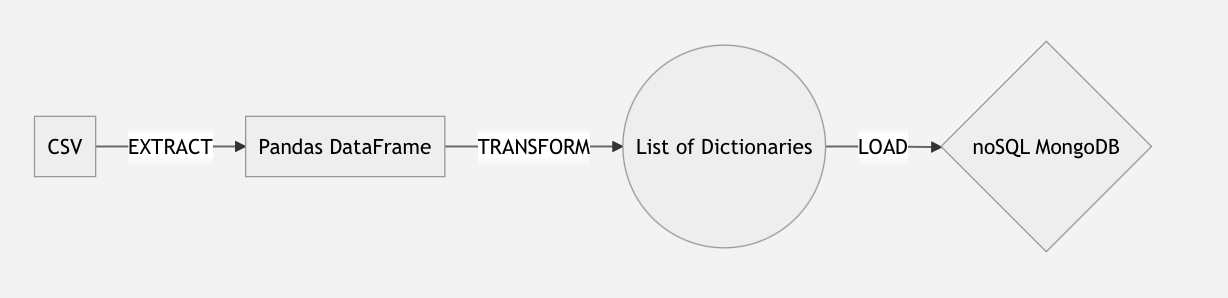


Importing modules

In [ ]:
import pandas as pd
import os
!pip install pymongo
import pymongo # often, this will need to be pip installed in, see line above
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi



Setting up MongoDB with Python

In [ ]:
# Credential params required to establish connection with MongoDB
provided_URI = "mongodb+srv://cluster0.rqb9xp1.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
path_to_certificate = "/content/X509-cert-359057758107592091.pem"

# Initializing a MongoClient Object, which is a MongoDB instance in the system
client = MongoClient(provided_URI,
                     tls=True,
                     tlsCertificateKeyFile=path_to_certificate,
                     server_api=ServerApi('1'))

# Initializing a database within the instance
database = client['SFL_SDE_evaluation_nathan']

# Initializing a collection within the database
collection = database['SRDataEngineerChallenge_DATASET']



Reading in the csv with pandas




In [ ]:
# Enter CSV path
csv_url = '/content/SRDataEngineerChallenge_DATASET.csv'

# Using read_csv function from pandas to read in the csv
df = pd.read_csv(csv_url)

# A quick preview what the dataframe looks like
df.head()


Converting the dataframe into a list of dictionaries

In [ ]:
# initializing column name as key
id = df.columns[0]
first_name = df.columns[1]
last_name = df.columns[2]
email = df.columns[3]
gender = df.columns[4]
ip_address = df.columns[5]

# initializing an empty list to append to
df_in_listFormat = list()

'''
  Nesting a dictionary into a list, 
  e.g 
  [{'id': 1, 
  'first_name':'Margaretta', 
  'last_name':'Laughtisse', 
  'email':'mlaughtisse0@mediafire.com', 
  'gender':'Genderfluid', 
  'ip_address':'34.148.232.131'}]
'''

for row in df.itertuples(index=False):
  # creating a dictionary of key, value from column name, value
  dictionary ={id: row.id, 
               first_name: row.first_name,
               last_name: row.last_name,
               email: row.email,
               gender: row.gender,
               ip_address: row.ip_address
               }
  
  # appending it to the list
  df_in_listFormat.append(dictionary)


Inserting the list into the collection to the MongoDB

In [ ]:
collection.insert_many(df_in_listFormat)


A screenshot result of the noSQL database on MongoDB

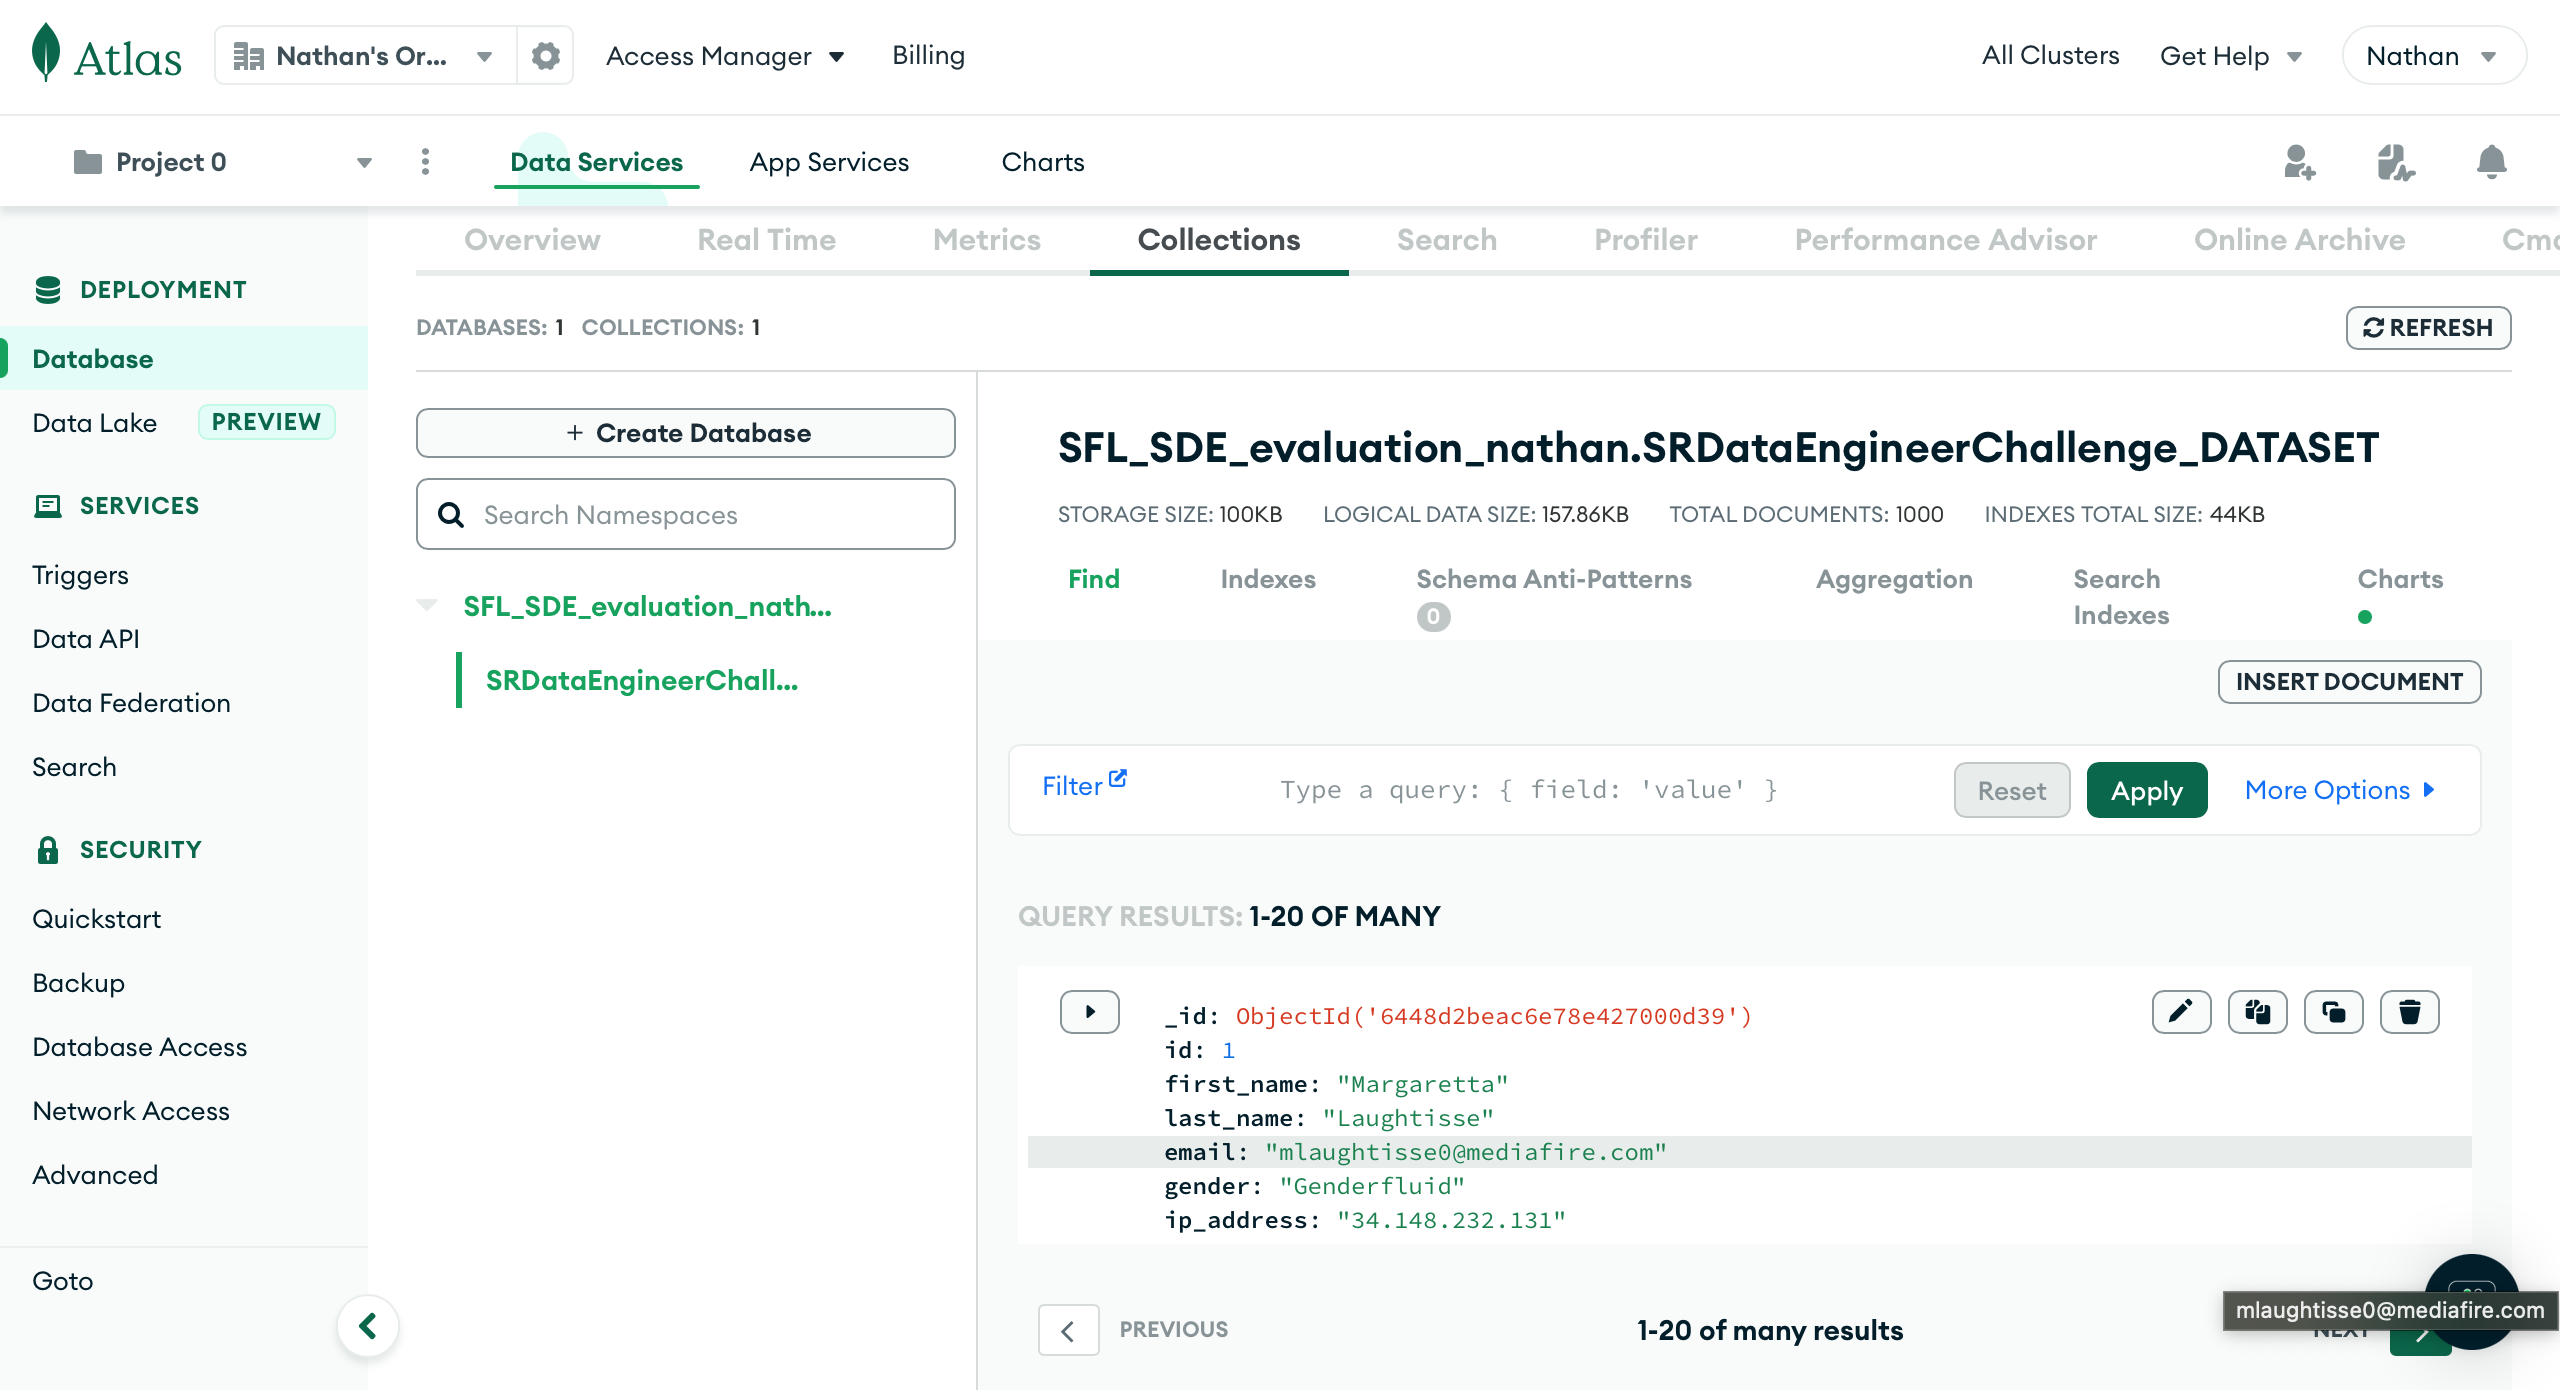

---
# Section 3
###ML API
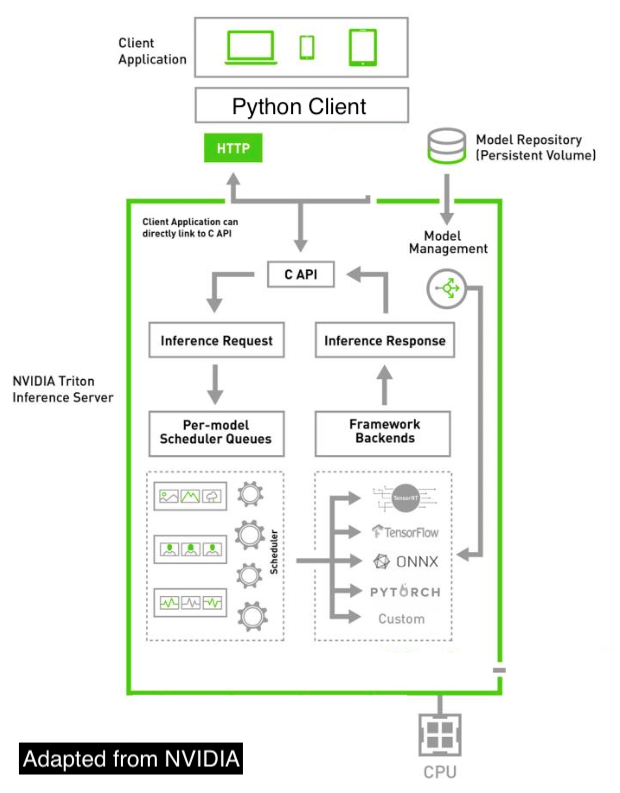

Importing modules, eg. Pytorch, Pytorchlightning and Mnist Data

In [ ]:
!pip install lightning
!pip install torch

import json
import lightning as L
import torch as T
import torch.nn.functional as F

from torch import nn
from torchmetrics.functional import accuracy
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from torchvision.datasets import MNIST, FashionMNIST # importing the MNIST Dataset from torchvision. It is a Hello-World dataset and any ML dataloader library should have them

!pip install attrdict
!pip install nvidia-pyindex
!pip install tritonclient[all]

import attrdict
import tritonclient
import numpy as np
import tritonclient.http as httpclient
from tritonclient.utils import triton_to_np_dtype

# global Var
DATASET_PATH = os.environ.get("PATH_DATASETS", ".")
INPUT_DIM = (1, 28, 28) # 28 by 28 grayscale input, 1 channel eg. (c, w, h)


In [ ]:
class Model(L.LightningModule):
    def __init__(self, channels, width, height, num_classes, hidden_size=64, learning_rate=2e-3):
        super().__init__()

        # initializing params eg. input dimensions .. to build the model.
        self.width = width
        self.height = height
        self.channels = channels
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = T.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = T.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = T.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

Setting up the dataloader to feed data into training



In [ ]:
class MNISTModule(L.LightningDataModule):
    def __init__(self, data_dir: str = DATASET_PATH):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)), # not sure about these params but Yann LeCun likes them.
            ]
        )

        self.dims = INPUT_DIM 
        self.num_classes = 10 # 10 digits

    def prepare_data(self):
        # downloading and creating the proper directories to save them
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # assign training/validation datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=64)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=64)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=64)

In [ ]:
# initializing DataModule
datamodule = MNISTModule()
# initializing Model from datamodule's attributes
model = Model(*datamodule.dims, datamodule.num_classes)
# initializing the trainer
trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices="auto",
)
# fit DataModule to model
trainer.fit(model, datamodule)

Saving the checkpoint to torchscript file for deployment

In [ ]:
saved_model = model.to_torchscript()
T.jit.save(saved_model, '/content/model.pt')

Setting up a NVIDIA Triton Inference Server inside a Docker Container on GCP.



```
# In Ubuntu 18.04, if Docker is not installed
sudo snap install docker
```

```
# Create the model repository, the latest version is 23.04 but 23.03 will do
git clone -b r23.03 https://github.com/triton-inference-server/server.git

```



```
# Setting up the deployment directory where we deploy model.pt

model_repository
|
+-- mnist
    |
    +-- config.pbtxt
    +-- 1
        |
        +-- model.pt
```

```
#  config.pbtxt must be configured as following

name: "mnist"
platform: "pytorch_libtorch"
max_batch_size : 0
input [
  {
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ 1, 28, 28, -1 ]
  }
]
output [
  {
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ -1, 10]
  }
]
```

```
# Initiate a Triton Docker Container, with CPUs
docker run --rm --net=host -v ${PWD}/model_repository:/models nvcr.io/nvidia/tritonserver:23.03-py3 tritonserver --model-repository=/models
```







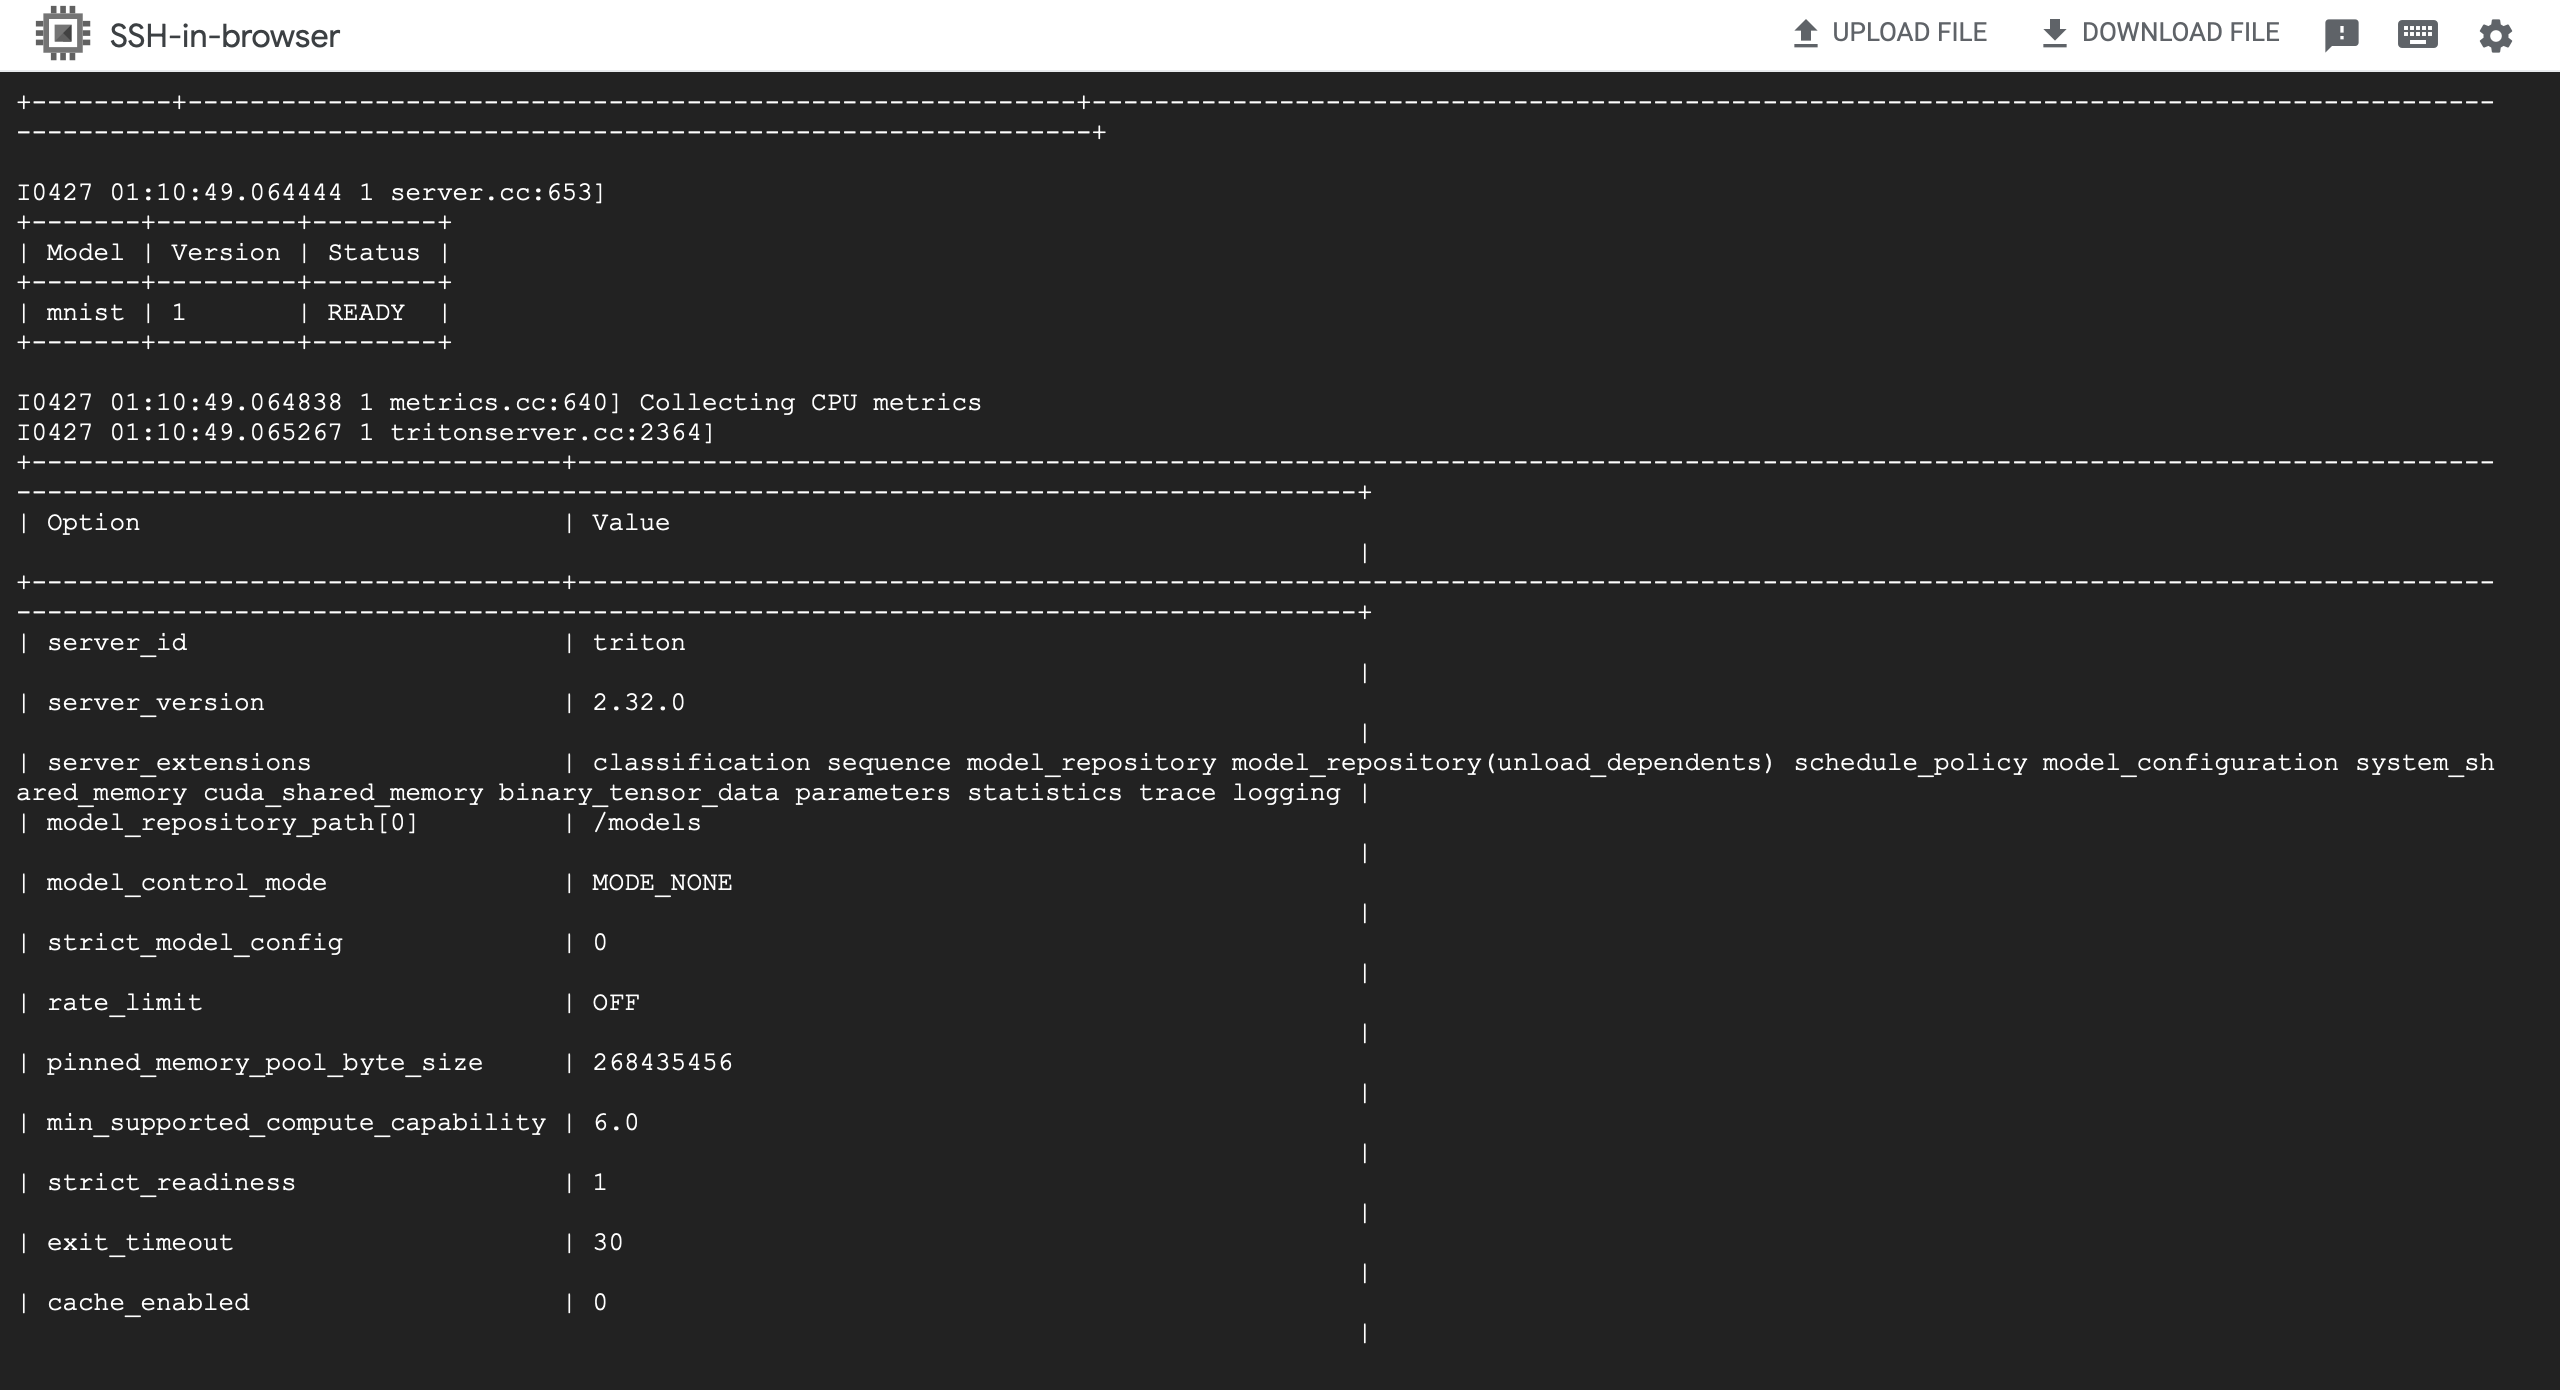

In [ ]:
# pulling the test set
test_set =MNIST(root='./data', train=False, download=True, transform=None)

# making example inference requests
for count, image_label in enumerate(test_set):
  # showing the image
  image = image_label[0]

  # setting up client, Google Cloud Computer IP address is 34.136.246.142 and we opened the port 8000 for the container
  client = httpclient.InferenceServerClient(url="34.136.246.142:8000")
  test_image = np.array(T.tensor(np.array(image).astype(np.float32)))
  test_image = np.expand_dims(test_image, axis = (0, 3)) # to make its shape to (1, 28,28,1)
  inputs = httpclient.InferInput("input__0", test_image.shape, datatype="FP32")

  inputs.set_data_from_numpy(test_image, binary_data=True)
  outputs = httpclient.InferRequestedOutput("output__0", binary_data=True, class_count=10)

  # querying the server, an inference request to the Triton Inference Server
  results = client.infer(model_name="mnist", inputs=[inputs], outputs=[outputs])
  inference_output = results.as_numpy('output__0')
  result = inference_output[np.argmax(inference_output)]

  # # show image
  image.show()
  # converting byte to string and split
  print(f"Label: {image_label[1]}  Prediction: {result.decode('utf-8').split(':')[1]}")

  if count == 10:
    break

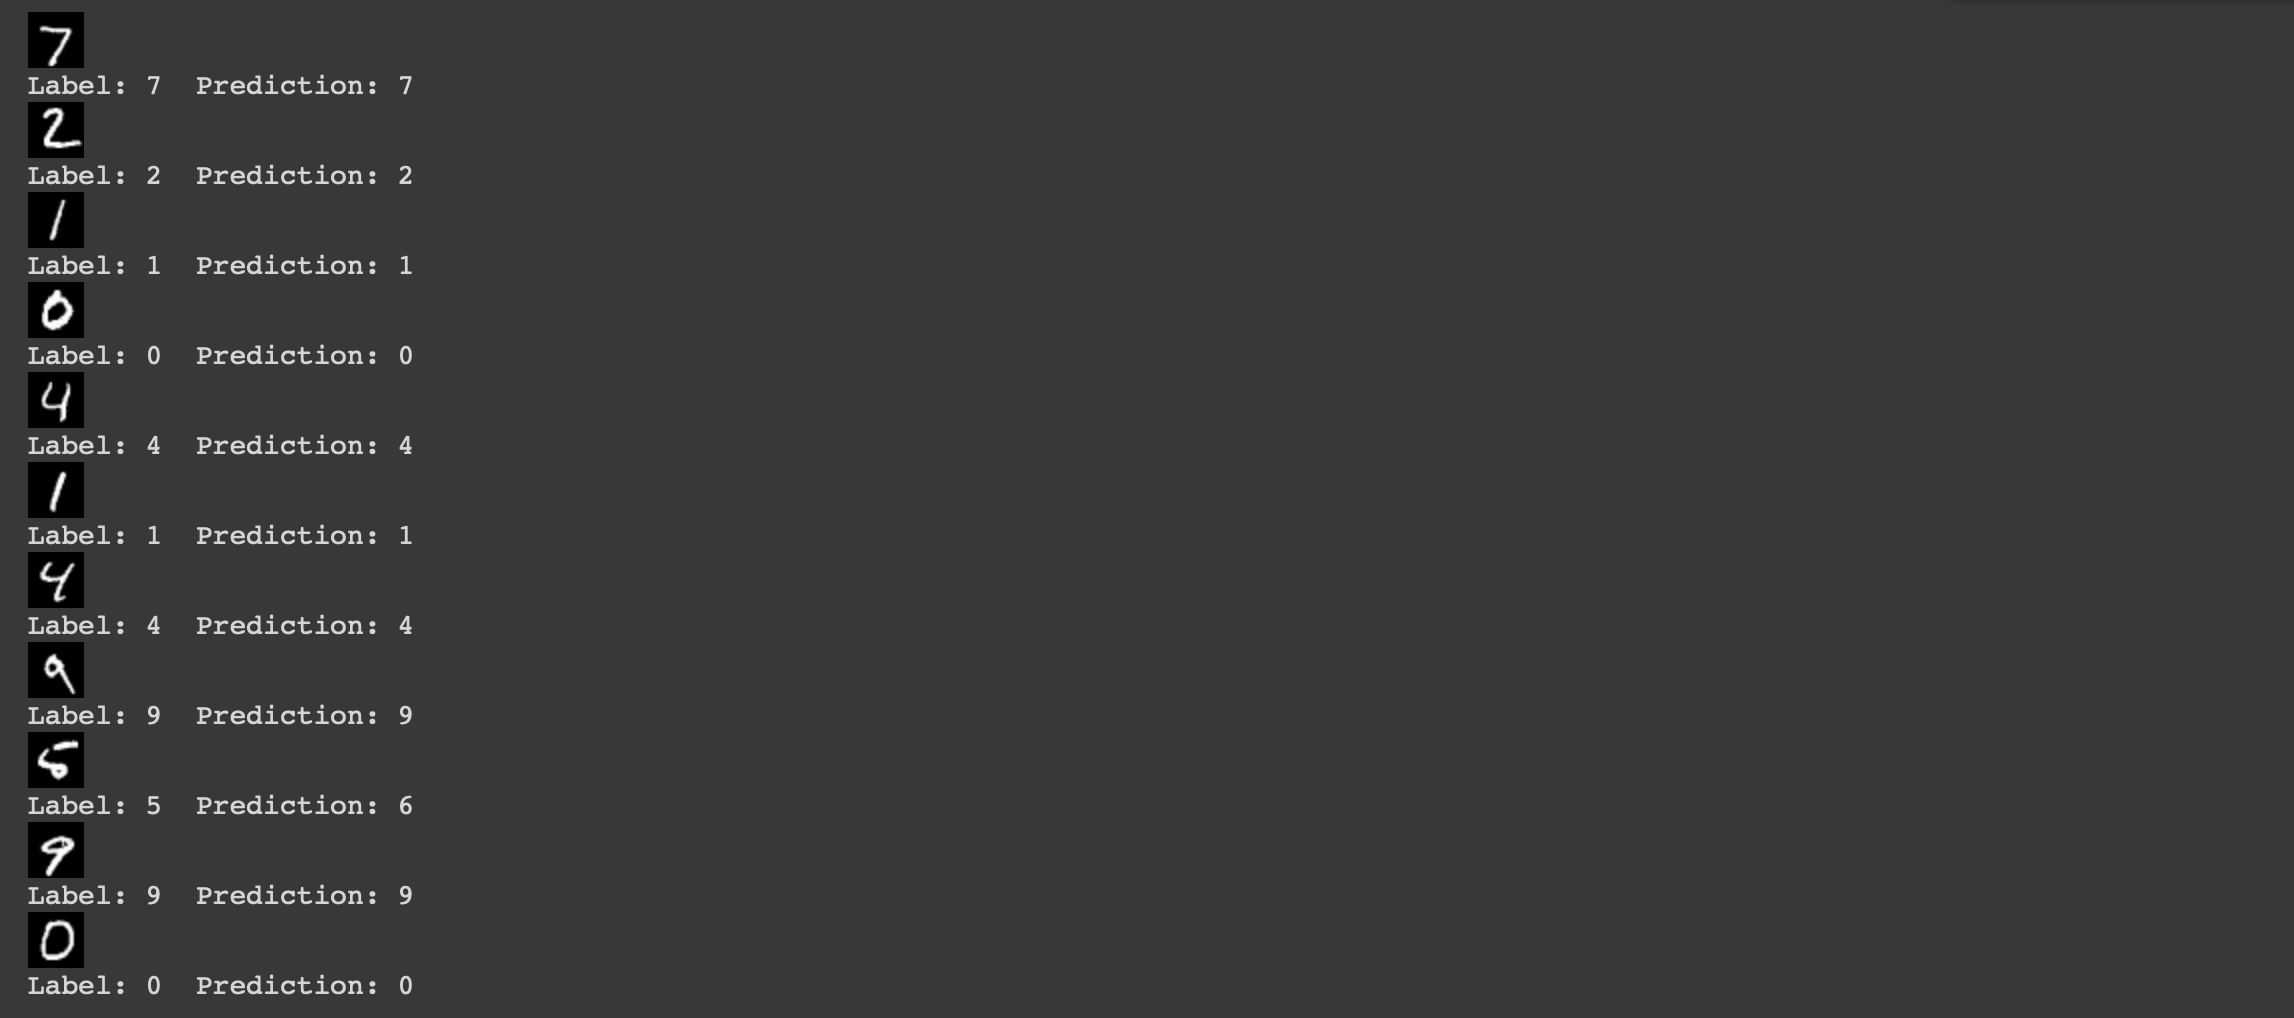

### State-of-the-Art Production Deployment (eg. Scalability Orchestration)
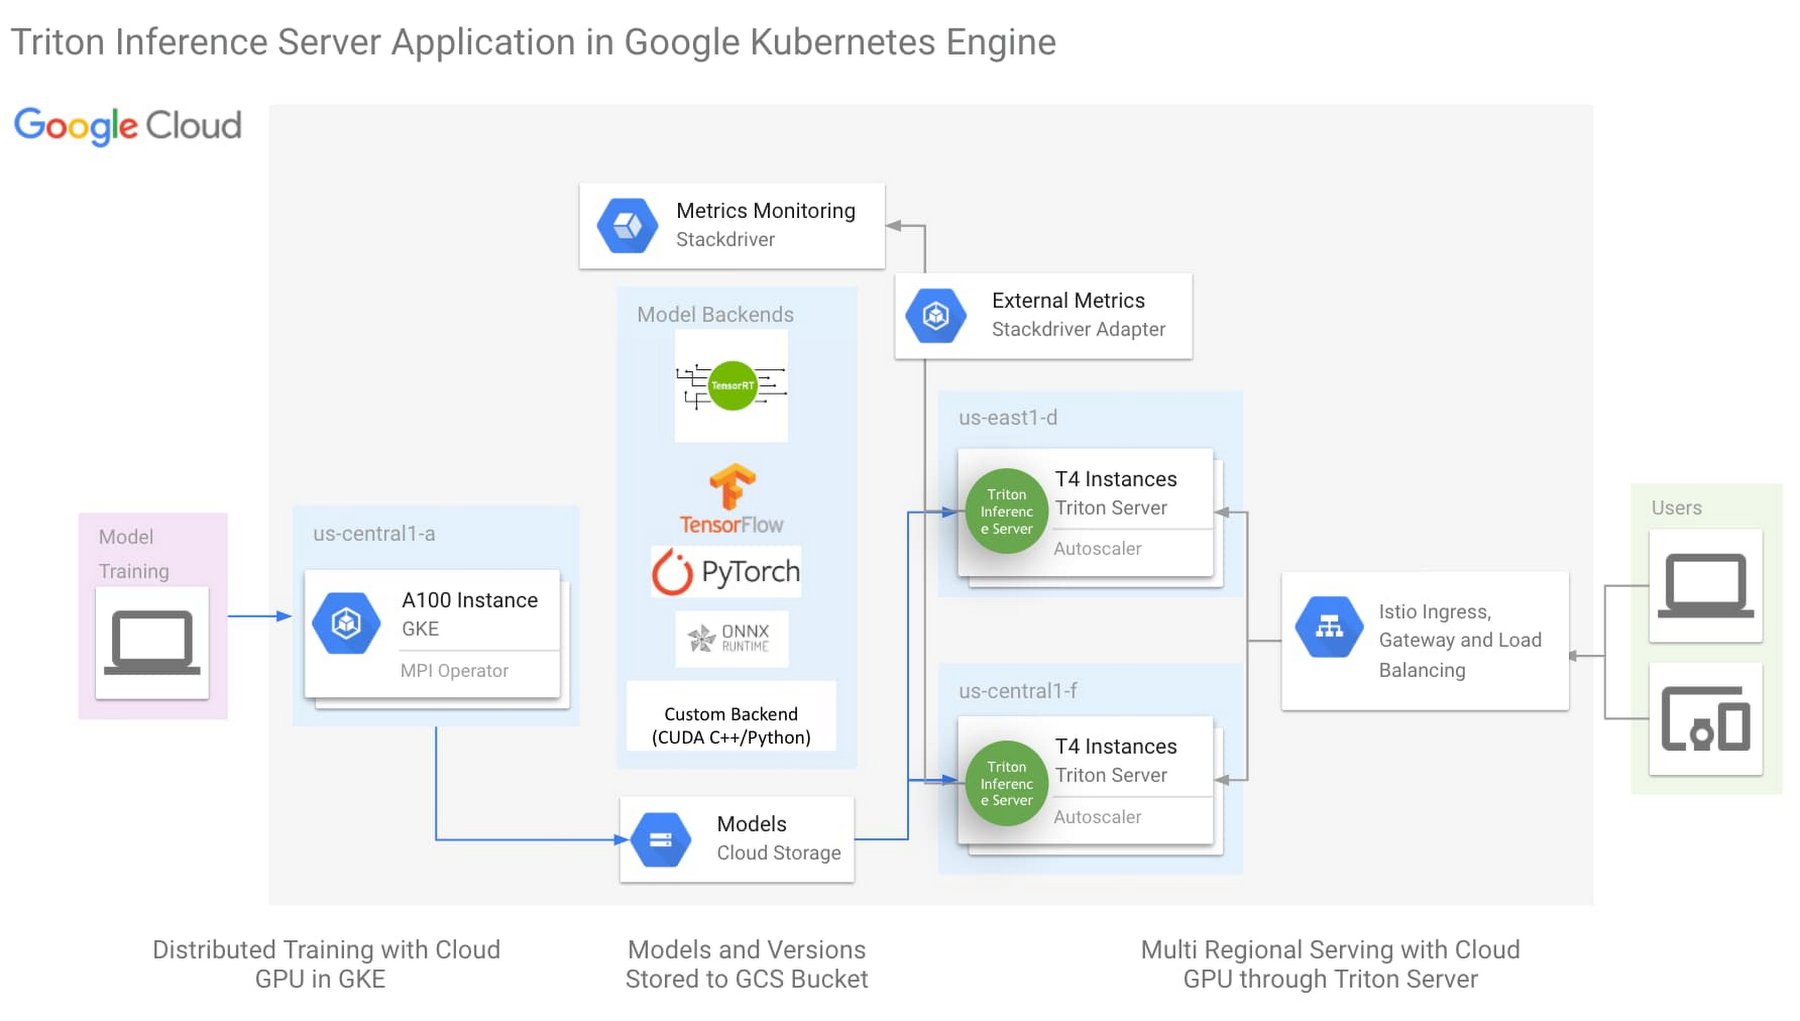